In [230]:
# import packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols, glm
import scipy.stats
from statsmodels.api import families

In [231]:
# set directory
os.chdir(os.getcwd().strip('notebooks'))

## Property internal features analysis 

In this Section we will be examining the correlation of property internal features, such as property type, number of beds/baths/parking to the rental price of the properties. Relevant features will be selected for modelling in the next stage

In [232]:
# read in cleaned rental properties
rental_data =pd.read_csv('data/curated/rental_properties_cleaned.csv')

In [233]:
# drop irrelevant columns
rental_data.drop(columns = ['Unnamed: 0.1', 'index'], inplace = True)

In [234]:
# factorize certain columns
rental_data.share_flag = rental_data.share_flag.astype('category')

In [235]:
# examine the correlation between the internal attributes of rental property; numerical
corr = rental_data.corr()
corr.style.background_gradient(cmap='coolwarm')

,cost_text,beds,baths,parking,under 20 (%),20 - 39 (%),40 - 59 (%),60 +(%)
cost_text,1.000000,0.327619,0.429125,0.168736,-0.064960,-0.020682,0.052148,0.056156
beds,0.327619,1.000000,0.561293,0.498181,0.439415,-0.394344,0.172712,0.190035
baths,0.429125,0.561293,1.000000,0.349729,0.215633,-0.139304,0.078570,0.012851
parking,0.168736,0.498181,0.349729,1.000000,0.344187,-0.352168,0.193757,0.185461
under 20 (%),-0.064960,0.439415,0.215633,0.344187,1.000000,-0.689261,0.491546,0.056000
20 - 39 (%),-0.020682,-0.394344,-0.139304,-0.352168,-0.689261,1.000000,-0.633140,-0.700462
40 - 59 (%),0.052148,0.172712,0.078570,0.193757,0.491546,-0.633140,1.000000,0.103430
60 +(%),0.056156,0.190035,0.012851,0.185461,0.056000,-0.700462,0.103430,1.000000


Many of the features appear to be highly correlated with one another and not correlated with the response variable, we will drop all of these

In [236]:
# many of the features are correlated, we will drop correlated features that also have low correlation with response variable
rental_data.drop(columns = ['beds', 'parking', 'under 20 (%)', '20 - 39 (%)', '40 - 59 (%)', '60 +(%)'], inplace = True)

In [237]:
# correlation between categorical atts 
# function borrowed from https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
from scipy.stats import chi2_contingency
import association_metrics as am
# function to calculate cramer's v
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [238]:
# define categorical variables
rental_categorical = rental_data[['share_flag', 'property_type']].astype('category')

In [239]:
# Initialize a CramersV object 
cramers_v = am.CramersV(rental_categorical)
# It will return a pairwise matrix filled with Cramer's V, where 
# columns and index are the categorical variables of the passed     # pandas.DataFrame
cfit = cramers_v.fit().round(2)
cfit

,share_flag,property_type
share_flag,1.00,0.07
property_type,0.07,1.00


### Modelling (reduced)

The only features that remain after selection are: property type, share flag and number of bedrooms. We will explore these possible predictors with a few statistical models in this section 

In [240]:
# generate a simple linear model
fit_OLS = ols(
   formula = "cost_text ~ share_flag + property_type + baths", data = rental_data
).fit()

In [241]:
# check the fit of the model
fit_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              cost_text   R-squared:                       0.196
Model:                            OLS   Adj. R-squared:                  0.194
Method:                 Least Squares   F-statistic:                     114.7
Date:                Wed, 28 Sep 2022   Prob (F-statistic):          1.15e-298
Time:                        20:03:37   Log-Likelihood:                -45738.
No. Observations:                6600   AIC:                         9.151e+04
Df Residuals:                    6585   BIC:                         9.161e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
Intercept                                        436.6856    111.419      3.919      0.000     218.269     655.103
share_flag[T.1]                                  -98.9762     28.277     -3.500      0.000    -154.408     -43.545
property_type[T.Apartment / Unit / Flat]        -200.5210    110.995     -1.807      0.071    -418.108      17.066
property_type[T.Carspace]                       -434.4105    134.005     -3.242      0.001    -697.104    -171.717
property_type[T.Duplex]                         -344.1598    207.271     -1.660      0.097    -750.479      62.159
property_type[T.House]                          -220.9603    110.908     -1.992      0.046    -438.377      -3.544
property_type[T.New Apartments / Off the Plan]  -261.6727    207.260     -1.263      0.207    -667.970     144.625
property_type[T.Rural]                           166.6649    271.324      0.614      0.539    -365.217     698.547
property_type[T.Semi-Detached]                    -1.1186    150.053     -0.007      0.994    -295.272     293.035
property_type[T.Studio]                         -369.0153    113.736     -3.244      0.001    -591.975    -146.055
property_type[T.Terrace]                          -8.1031    145.114     -0.056      0.955    -292.573     276.367
property_type[T.Townhouse]                      -233.7213    111.184     -2.102      0.036    -451.678     -15.764
property_type[T.Villa]                          -242.2892    124.608     -1.944      0.052    -486.562       1.984
property_type[T.storage unit]                   -411.8010    150.461     -2.737      0.006    -706.753    -116.849
baths                                            198.3247      5.472     36.241      0.000     187.597     209.052
==============================================================================
Omnibus:                     7638.805   Durbin-Watson:                   0.342
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1276670.954
Skew:                           5.881   Prob(JB):                         0.00
Kurtosis:                      70.112   Cond. No.                         264.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

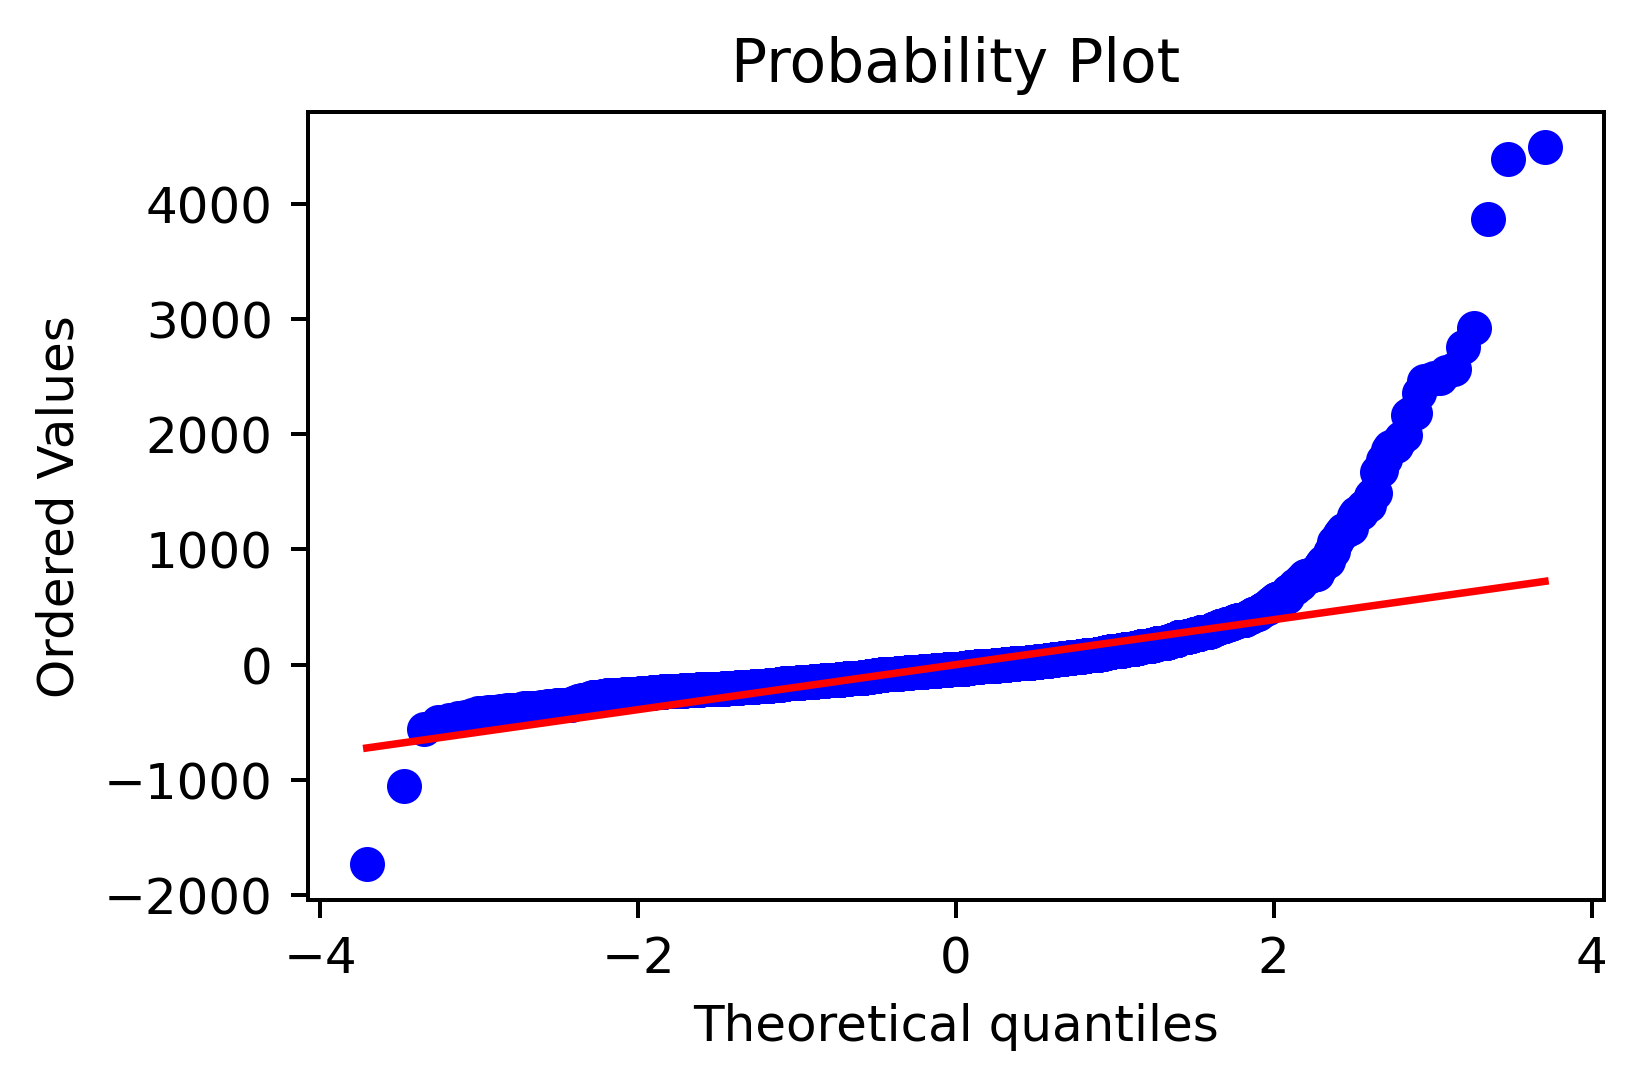

In [242]:
# plot residuals of the models
fig = plt.figure(figsize=(6,3))
headerfont = {'fontname':'Arial', 'fontsize':12}
plt.rcParams['figure.dpi'] = 360 # increase sharpness of chart
plt.gcf().subplots_adjust(bottom=0.15, left = 0.3)
ax = plt.subplot(111)
graph_DO = scipy.stats.probplot(fit_OLS.resid, plot=plt)

plt.show()

In [243]:
# residuals show heavy tails, perhaps a negative binomial model is more suitable?
fit_NB= glm(
    formula = "cost_text ~ share_flag + property_type + baths", data = rental_data,
    family=families.NegativeBinomial()
).fit()


In [244]:
fit_NB.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              cost_text   No. Observations:                 6600
Model:                            GLM   Df Residuals:                     6585
Model Family:        NegativeBinomial   Df Model:                           14
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -47534.
Date:                Wed, 28 Sep 2022   Deviance:                       761.38
Time:                        20:03:38   Pearson chi2:                 1.15e+03
No. Iterations:                     7   Pseudo R-squ. (CS):            0.05325
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
Intercept                                          6.1067      0.450     13.567      0.000       5.224       6.989
share_flag[T.1]                                   -0.2288      0.114     -2.002      0.045      -0.453      -0.005
property_type[T.Apartment / Unit / Flat]          -0.3456      0.448     -0.771      0.441      -1.224       0.533
property_type[T.Carspace]                         -2.1528      0.543     -3.967      0.000      -3.217      -1.089
property_type[T.Duplex]                           -0.4729      0.837     -0.565      0.572      -2.114       1.168
property_type[T.House]                            -0.3540      0.448     -0.790      0.429      -1.232       0.524
property_type[T.New Apartments / Off the Plan]    -0.4378      0.838     -0.523      0.601      -2.079       1.204
property_type[T.Rural]                             0.1647      1.096      0.150      0.881      -1.983       2.313
property_type[T.Semi-Detached]                     0.0039      0.606      0.006      0.995      -1.184       1.192
property_type[T.Studio]                           -0.8487      0.459     -1.847      0.065      -1.749       0.052
property_type[T.Terrace]                           0.0057      0.586      0.010      0.992      -1.143       1.155
property_type[T.Townhouse]                        -0.3707      0.449     -0.825      0.409      -1.251       0.510
property_type[T.Villa]                            -0.4256      0.503     -0.845      0.398      -1.412       0.561
property_type[T.storage unit]                     -2.8924      0.613     -4.717      0.000      -4.094      -1.691
baths                                              0.3182      0.022     14.388      0.000       0.275       0.362
==================================================================================================================
"""

In [245]:
# perform an anova on the linear regression model
anova_table = sm.stats.anova_lm(fit_OLS)

In [246]:
# from the anova table, it appears that all features selected in this section are significant
anova_table

,df,sum_sq,mean_sq,F,PR(>F)
share_flag,1.0,1.276560e+06,1.276560e+06,20.809166,5.165883e-06
property_type,12.0,1.663056e+07,1.385880e+06,22.591184,6.667335e-50
baths,1.0,8.057247e+07,8.057247e+07,1313.409399,2.125795e-262
Residual,6585.0,4.039637e+08,6.134605e+04,NaN,NaN


This section's analysis and modelling results suggest that the number of baths, property type and whether the property is shared or not is significant to the rental prices of the property. However, it appears that the variables are too simplistic on their own as predictors. Hence we will explore other external factors but retain these three features for our final modelling

## SA2 specific features analysis

In [247]:
# read in all SA2 specific features
SA2_features_raw = pd.read_csv('data/curated/external_features(SA2).csv')

In [248]:
SA2_features_raw.sort_values(by = ['SA2 name'], inplace = True) # sort alphabetically

In [249]:
# replace string values
SA2_features_raw = SA2_features_raw.replace(['np'],'0')

In [250]:
SA2_features= SA2_features_raw.copy() # copy a df over for prelim. analysis (individual)

In [251]:
# drop irrelevant columns
SA2_features.drop(columns = ['pop_2021', 'Unnamed: 0','property_type','LGA code','SA2 code','SA2 name'], inplace = True)

In [252]:
# convert all columns to numerical 
for column in SA2_features.columns:
    print(column)
    SA2_features[column]=SA2_features[column].astype(float)

cost_text
Area
Children_population
Early_Working_age_population
Prime_Working_age_population
Mature_Working_age_population
Elderly_population
2021 crime rate
Median $ 2019
Mean $ 2019


In [253]:
# examine the correlation between the internal attributes of rental property; numerical
corr_2 = SA2_features .corr()
corr_2.style.background_gradient(cmap='coolwarm')

,cost_text,Area,Children_population,Early_Working_age_population,Prime_Working_age_population,Mature_Working_age_population,Elderly_population,2021 crime rate,Median $ 2019,Mean $ 2019
cost_text,1.000000,-0.046923,-0.093739,0.013335,0.016935,0.030803,0.006478,0.139150,0.227290,0.295746
Area,-0.046923,1.000000,-0.059354,-0.122233,-0.181384,0.011818,-0.125708,-0.053847,-0.158041,-0.122861
Children_population,-0.093739,-0.059354,1.000000,0.175099,0.490330,0.556068,0.725779,-0.509664,-0.049792,-0.165628
Early_Working_age_population,0.013335,-0.122233,0.175099,1.000000,0.578806,0.096115,0.550569,0.302125,-0.228591,-0.091801
Prime_Working_age_population,0.016935,-0.181384,0.490330,0.578806,1.000000,0.343059,0.825101,0.132554,0.113782,0.000263
Mature_Working_age_population,0.030803,0.011818,0.556068,0.096115,0.343059,1.000000,0.753091,-0.431162,-0.162908,-0.055228
Elderly_population,0.006478,-0.125708,0.725779,0.550569,0.825101,0.753091,1.000000,-0.201697,-0.071558,-0.057384
2021 crime rate,0.139150,-0.053847,-0.509664,0.302125,0.132554,-0.431162,-0.201697,1.000000,0.131763,0.209201
Median $ 2019,0.227290,-0.158041,-0.049792,-0.228591,0.113782,-0.162908,-0.071558,0.131763,1.000000,0.840739
Mean $ 2019,0.295746,-0.122861,-0.165628,-0.091801,0.000263,-0.055228,-0.057384,0.209201,0.840739,1.000000


Disappointingly, only mean income seem to be moderately correlated with with individual rental prices, however, we are still interested to see if these features are correlated with the mean and median prices of each SA2

In [254]:
# get mean and median rental price of each SA2
SA2_mean_price = SA2_features_raw.groupby('SA2 name')['cost_text'].mean()
SA2_median_price = SA2_features_raw.groupby('SA2 name')['cost_text'].median()

In [255]:
SA2_features_raw

,Unnamed: 0,cost_text,property_type,LGA code,SA2 code,SA2 name,pop_2021,Area,Children_population,Early_Working_age_population,Prime_Working_age_population,Mature_Working_age_population,Elderly_population,2021 crime rate,Median $ 2019,Mean $ 2019
2514,2514,675.0,Apartment / Unit / Flat,Yarra,206071139,Abbotsford,9262,1.7,759,905,6450,578,9832,0.118272,64090,78181
2531,2531,575.0,Apartment / Unit / Flat,Yarra,206071139,Abbotsford,9262,1.7,759,905,6450,578,9832,0.118272,64090,78181
2530,2530,400.0,Apartment / Unit / Flat,Yarra,206071139,Abbotsford,9262,1.7,759,905,6450,578,9832,0.118272,64090,78181
2529,2529,420.0,Apartment / Unit / Flat,Yarra,206071139,Abbotsford,9262,1.7,759,905,6450,578,9832,0.118272,64090,78181
2528,2528,950.0,House,Yarra,206071139,Abbotsford,9262,1.7,759,905,6450,578,9832,0.118272,64090,78181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6554,6554,495.0,Studio,Moira,216021414,Yarrawonga,8585,94.7,1364,752,2986,1367,10701,0.053705,41980,49703
6472,6472,320.0,House,Northern Grampians,215011394,Yarriambiack,6454,7139.6,1015,586,2412,1105,7790,0.075221,44238,52472
6473,6473,295.0,House,Northern Grampians,215011394,Yarriambiack,6454,7139.6,1015,586,2412,1105,7790,0.075221,44238,52472
538,538,600.0,House,Mitchell,204011062,Yea,4142,1474.3,566,362,1599,815,4942,0.063662,38638,49593


In [267]:
# get all SA2 specific features into the new df
SA2_data = pd.DataFrame()
SA2_data['rental_price_mean'] = SA2_mean_price
SA2_data['rental_price_median'] = SA2_median_price
SA2_data.reset_index(inplace = True)

# iterate through pd frame and get SA2 features
for column in SA2_features_raw.iloc[[],6:].columns: 
    SA2_features_raw[column]=SA2_features_raw[column].astype(float)
    SA2_data = SA2_data.merge(SA2_features_raw.groupby('SA2 name')[str(column)].first(), left_on = ['SA2 name'], right_index = True)

# add another feature, specific crime number to the df
SA2_data['crime number'] = SA2_data['pop_2021']*SA2_data['2021 crime rate']
   

In [268]:
# examine correlation between SA2 mean and median and features
corr_3 = SA2_data .corr()
corr_3.style.background_gradient(cmap='coolwarm')

,rental_price_mean,rental_price_median,pop_2021,Area,Children_population,Early_Working_age_population,Prime_Working_age_population,Mature_Working_age_population,Elderly_population,2021 crime rate,Median $ 2019,Mean $ 2019,crime number
rental_price_mean,1.000000,0.903598,0.067605,-0.178826,-0.054034,0.053754,0.057415,0.134307,0.085003,0.099502,0.442488,0.580522,0.043540
rental_price_median,0.903598,1.000000,0.027309,-0.179645,-0.047728,0.018500,0.019178,0.079762,0.039332,0.037647,0.372644,0.467941,0.007394
pop_2021,0.067605,0.027309,1.000000,-0.274391,0.874170,0.877186,0.960316,0.774863,0.994777,-0.098305,0.211764,0.136705,0.692715
Area,-0.178826,-0.179645,-0.274391,1.000000,-0.241990,-0.286312,-0.302181,-0.089010,-0.261538,-0.010992,-0.292561,-0.212070,-0.216364
Children_population,-0.054034,-0.047728,0.874170,-0.241990,1.000000,0.715409,0.819670,0.574352,0.848337,-0.270665,0.199322,0.054493,0.441576
Early_Working_age_population,0.053754,0.018500,0.877186,-0.286312,0.715409,1.000000,0.859011,0.571632,0.856506,0.033808,0.177503,0.144387,0.715862
Prime_Working_age_population,0.057415,0.019178,0.960316,-0.302181,0.819670,0.859011,1.000000,0.615974,0.934684,0.022612,0.283796,0.167926,0.761432
Mature_Working_age_population,0.134307,0.079762,0.774863,-0.089010,0.574352,0.571632,0.615974,1.000000,0.823356,-0.213477,0.043607,0.074273,0.420861
Elderly_population,0.085003,0.039332,0.994777,-0.261538,0.848337,0.856506,0.934684,0.823356,1.000000,-0.115395,0.189304,0.134986,0.673923
2021 crime rate,0.099502,0.037647,-0.098305,-0.010992,-0.270665,0.033808,0.022612,-0.213477,-0.115395,1.000000,0.065540,0.125968,0.550966


Mean income has a high correlation with rental price mean, unfortunately the rest of the features still seem to be quite irrelevant

## POIs analysis

### Preliminaries

In [258]:
from numpy import arange
import matplotlib.pyplot as plt
from itertools import chain
import statsmodels.api as sm
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_validate

In [30]:
# Read in POI counts data
df = pd.read_csv('./data/curated/poi_counts.csv',index_col=0)

In [32]:
# Read in category types
with open('./data/curated/poi_types.txt', 'r') as fp:
    ls = fp.read().splitlines()

In [31]:
df

,coordinates,pitch,water,school,swimming_pool,parking,social_facility,fuel,mall,hardware,...,volcano,garden_furniture,swimming_area,heliport,summer_camp,brewing_supplies,perfumery,pillory,fort,cost
0,"[-36.253557, 144.944557]",12.0,16.0,2.0,8.0,6.0,4.0,2.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.000000
1,"[-36.554159, 146.7208003]",47.0,23.0,3.0,19.0,16.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.923077
2,"[-36.5530096, 146.7188613]",47.0,21.0,3.0,18.0,16.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.384615
3,"[-36.5380049, 145.9927626]",7.0,9.0,3.0,1.0,21.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.000000
4,"[-36.5424309, 145.9979175]",5.0,15.0,3.0,1.0,21.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5973,"[-37.8802849, 147.8299957]",0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,720.000000
5974,"[-37.8791032, 147.8273685]",0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,720.000000
5975,"[-38.1336473, 144.7061689]",0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,725.000000
5976,"[-38.372703, 144.7856897]",0.0,0.0,0.0,0.0,8.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,725.000000


Text(0.5, 1.0, 'Histogram of Distribution of Rental Costs')

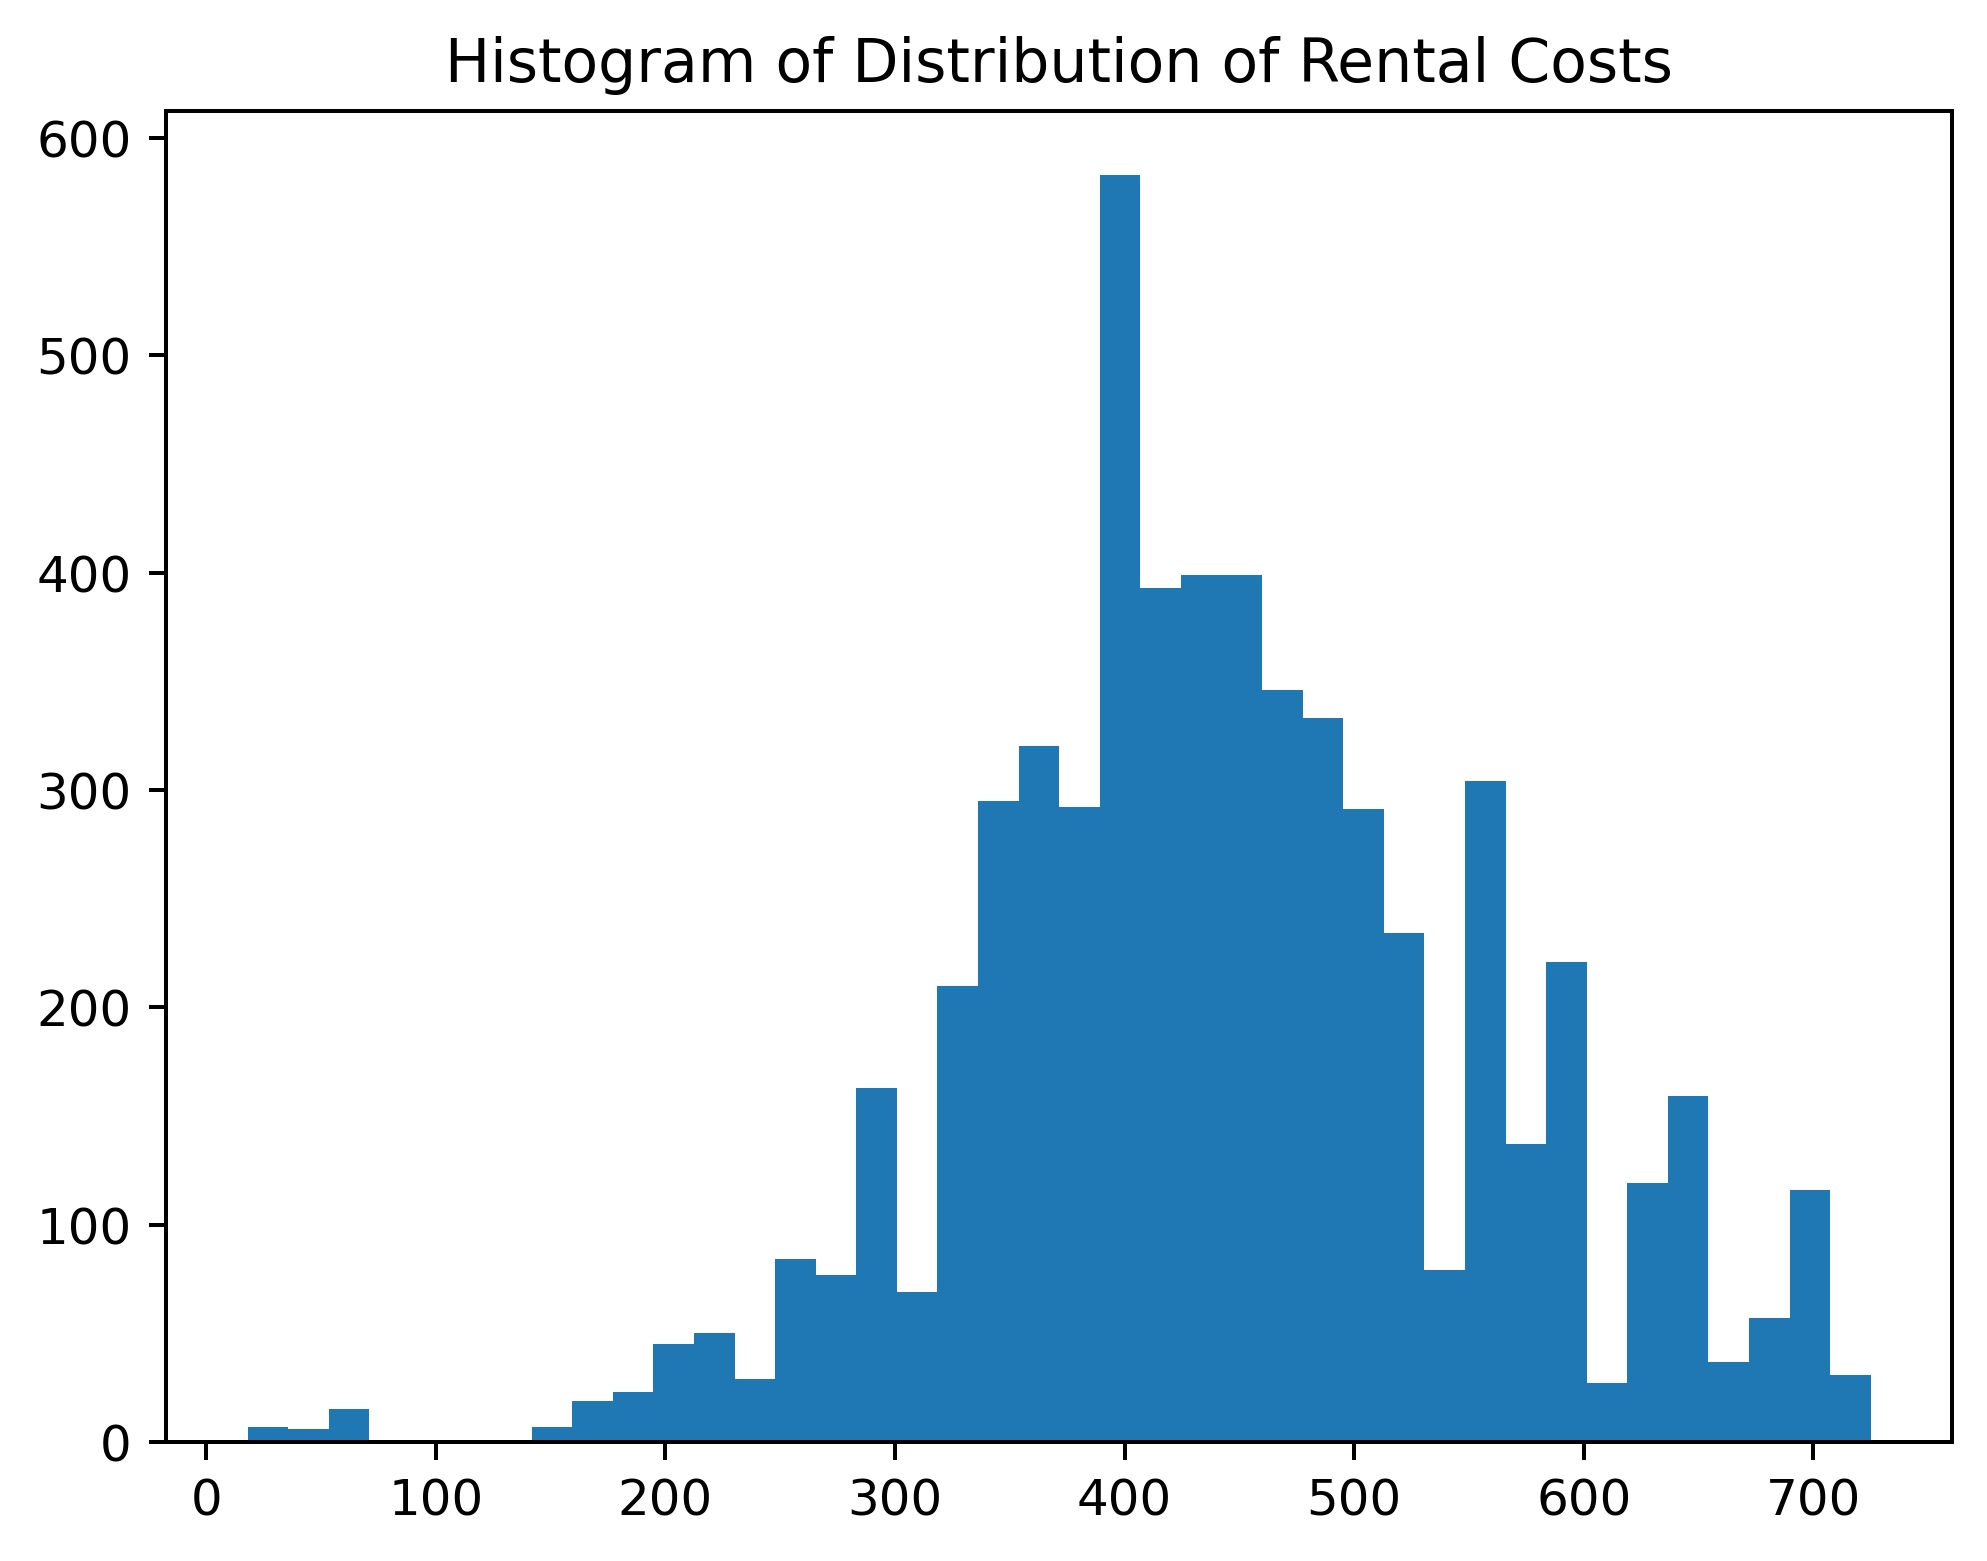

In [44]:
plt.hist(df['cost'], bins = 40)
plt.title('Histogram of Distribution of Rental Costs')

{'whiskers': [<matplotlib.lines.Line2D at 0x247113dc940>,
 'caps': [<matplotlib.lines.Line2D at 0x247113dce80>,
 'boxes': [<matplotlib.lines.Line2D at 0x247113dc6a0>],
 'medians': [<matplotlib.lines.Line2D at 0x247113dd3c0>],
 'fliers': [<matplotlib.lines.Line2D at 0x247113dd660>],
 'means': []}

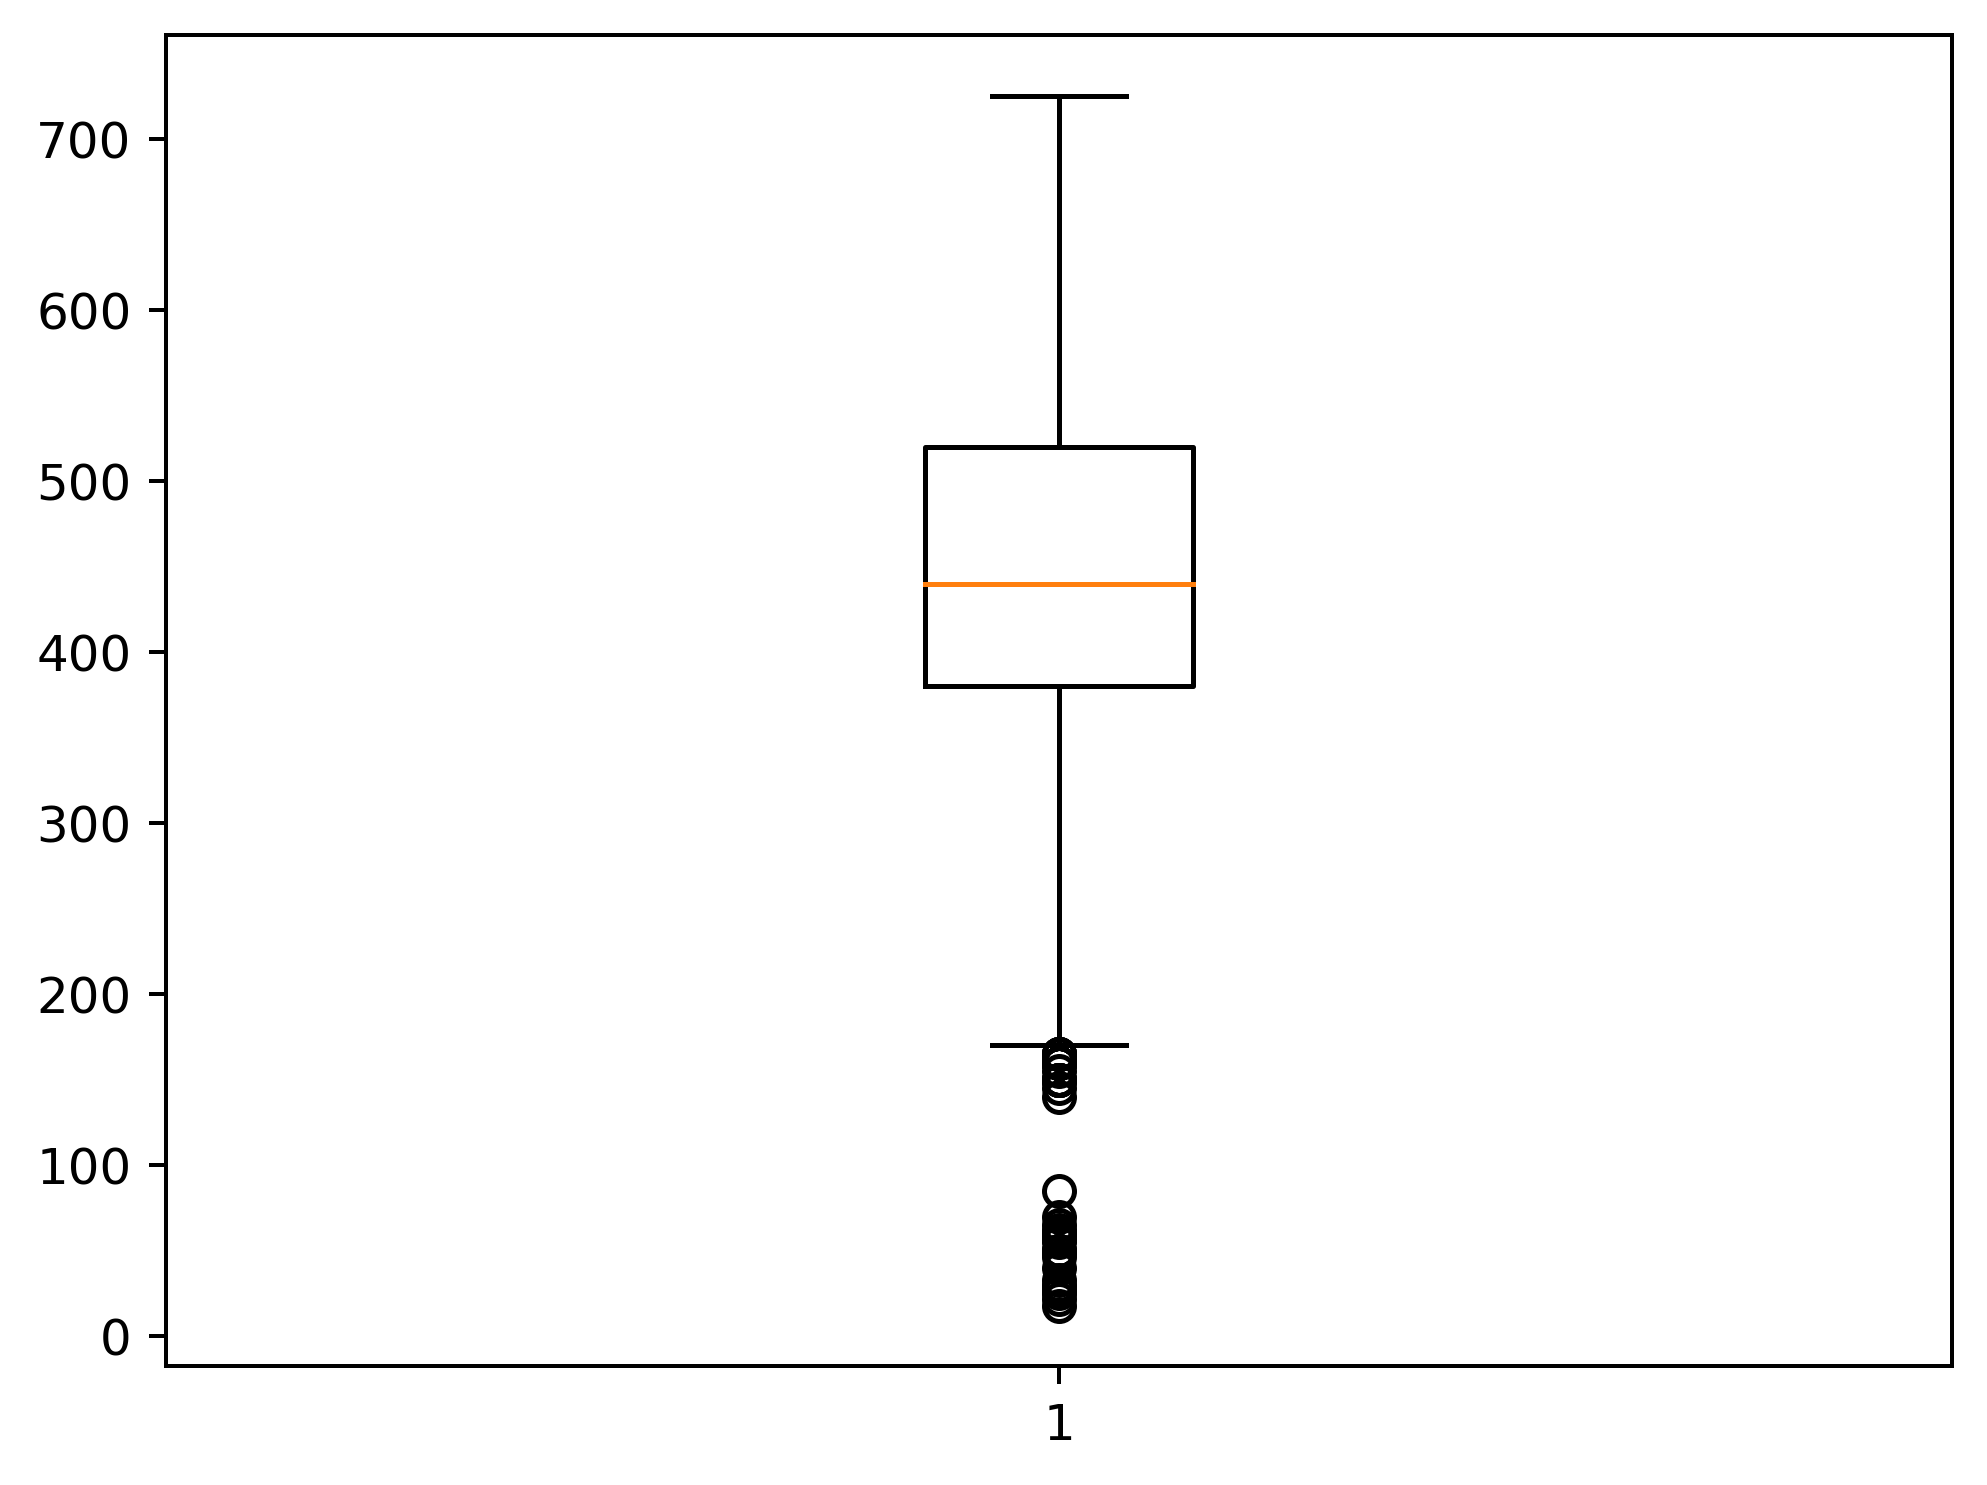

In [40]:
plt.boxplot(df['cost'])

From the 2 plots, we can see that there are a lot of outliers with low costs. They may be associated with the many storage units in listing.

### OLS Regression based on POI

In [45]:
def get_stats():
    x = df[ls]
    y = df['cost']
    results = sm.OLS(y, x).fit()
    print(results.summary())

In [46]:
get_stats()

                                 OLS Regression Results                                
Dep. Variable:                   cost   R-squared (uncentered):                   0.825
Model:                            OLS   Adj. R-squared (uncentered):              0.817
Method:                 Least Squares   F-statistic:                              99.96
Date:                Wed, 28 Sep 2022   Prob (F-statistic):                        0.00
Time:                        15:38:30   Log-Likelihood:                         -39924.
No. Observations:                5978   AIC:                                  8.039e+04
Df Residuals:                    5708   BIC:                                  8.220e+04
Df Model:                         270                                                  
Covariance Type:            nonrobust                                                  
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

The OLS model has a R^2 of 0.825, which is really good. However, it uses all the features, which loses out on generalisation.

### Modelling (reduced)

We now try and fit an elastic net regression model on the data.

#### Perform a grid search through values for alpha and penalty parameters of elastic net to find optimal values.

In [ ]:
X, y = df.iloc[:,1:-1], df.iloc[:,-1]
model = ElasticNet()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=1, random_state=1)
# define grid
grid = dict()
grid['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
grid['l1_ratio'] = arange(0, 1, 0.1)
# define search
search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=2)
# perform the search
results = search.fit(X, y)
# summarize
print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

### Create the elastic net model with optimal parameters

In [47]:
x = df[ls]
y = df['cost']

In [48]:
# Scale the columns
scaler = StandardScaler()
df_scaled = scaler.fit_transform(x)

In [49]:
net = ElasticNet(random_state=0, alpha=0.1, l1_ratio=0)
cross_validate(net, df_scaled, y, cv=10, n_jobs=2, scoring='r2')

{'fit_time': array([1.14988565, 1.12436914, 1.03779149, 1.04186344, 1.0563724 ,
        1.091151  , 1.07319188, 1.10985732, 1.05904222, 1.08967471]),
 'score_time': array([0.00153089, 0.00101733, 0.00101829, 0.00102139, 0.00102067,
        0.0015316 , 0.00204515, 0.00102091, 0.00050998, 0.00102139]),
 'test_score': array([-11.37857251, -64.690108  , -68.86075316, -97.15925732,
        -59.61938552, -55.7494883 , -22.03628535, -29.94174029,
        -40.55620691, -39.34240363])}

We can see that the variance of the R^2 value across the validation runs is very high.

In [51]:
net.fit(df_scaled,y)

c:\Users\aranw\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.198e+07, tolerance: 7.635e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


ElasticNet(alpha=0.1, l1_ratio=0, random_state=0)

In [52]:
coefs = net.coef_
remove_list = []
for i in range(len(coefs)):
    if abs(coefs[i]) < 0.05:
        remove_list.append(ls[i])

In [53]:
remove_list

['bar', 'erotic', 'radiotechnics']

In [54]:
len(remove_list)

3

In [55]:
columns = list(chain.from_iterable([['coordinates'],ls]))

In [56]:
df_reduce = df[columns].drop(remove_list, axis=1)

In [66]:
df_unique = pd.DataFrame(df_reduce.nunique(), columns=['Counts'])

In [69]:
df_unique[df_unique['Counts'] <= 5]

,Counts
agrarian,4
aerodrome,3
theme_park,4
locksmith,5
coworking_space,4
...,...
summer_camp,2
brewing_supplies,2
perfumery,2
pillory,2


#### There are quite a lot of features with few unique values. Most of these could be noise to the data, and will need to be filtered out.

## Final modelling (all relevant features)

### testing